<a href="https://colab.research.google.com/github/DarxinZ/ML/blob/main/DnD_Monster_Challenge_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DnD Monsters Callenge Rating Prediction...
Prediction of Monster challenge rating by variuse monster variables and abilities

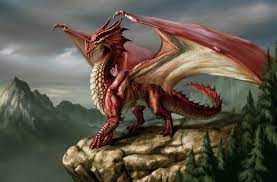



In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import minmax_scale, StandardScaler,MinMaxScaler,Normalizer,RobustScaler
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score


# source: https://www.kaggle.com/mrpantherson/dnd-5e-monsters
df = pd.read_csv('/content/drive/MyDrive/Data/dnd_monsters.csv')
df.columns

Index(['name', 'url', 'cr', 'type', 'size', 'ac', 'hp', 'speed', 'align',
       'legendary', 'source', 'str', 'dex', 'con', 'int', 'wis', 'cha'],
      dtype='object')

Columns explained:
* name : Monster name - not relevant for prediction
* url : URL source - not relevant for prediction
* cr : Challenge Rating, how difficult is the creature to defeat (1 to 24) - will be changed to ('low', 'mid', 'high')
* type: type of creature - not relevant for prediction
* size: size of monster, change to numeric 1 - 6
* ac : armor class - will be deleted, cause it's easy to change  acb by wearing different armor....
* hp: hit points (Health)
* speed: remove the column and make 2 new 'fly' , 'swim' - with values 0 (No) or 1(Yes) 
* align: Monster alignment - not relevant for prediction
* legendary: is legendary Monster - change to 0 (No), 1 (Yes)
* source: Book source - not relevant for prediction
* 'str', 'dex', 'con', 'int', 'wis', 'cha': score abilities - will be deleted more than half of the data missing...


In [299]:
df.head()

,name,url,cr,type,size,ac,hp,speed,align,legendary,source,str,dex,con,int,wis,cha
0,aarakocra,https://www.aidedd.org/dnd/monstres.php?vo=aar...,1/4,humanoid (aarakocra),Medium,12,13,fly,neutral good,NaN,Monster Manual (BR),10.00,14.00,10.00,11.00,12.00,11.00
1,abjurer,NaN,9,humanoid (any race),Medium,12,84,NaN,any alignment,NaN,Volo's Guide to Monsters,nan,nan,nan,nan,nan,nan
2,aboleth,https://www.aidedd.org/dnd/monstres.php?vo=abo...,10,aberration,Large,17,135,swim,lawful evil,Legendary,Monster Manual (SRD),21.00,9.00,15.00,18.00,15.00,18.00
3,abominable-yeti,NaN,9,monstrosity,Huge,15,137,NaN,chaotic evil,NaN,Monster Manual,nan,nan,nan,nan,nan,nan
4,acererak,NaN,23,undead,Medium,21,285,NaN,neutral evil,NaN,Adventures (Tomb of Annihilation),nan,nan,nan,nan,nan,nan


In [300]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ac,762.00,14.58,3.14,0.00,12.00,14.00,17.00,25.00
hp,762.00,88.13,94.82,0.00,22.00,58.00,126.00,676.00
str,401.00,15.23,6.49,1.00,11.00,16.00,19.00,30.00
dex,401.00,12.75,3.18,1.00,10.00,13.00,15.00,28.00
con,401.00,15.15,4.38,8.00,12.00,14.00,17.00,30.00
int,401.00,8.32,5.69,1.00,3.00,8.00,12.00,26.00
wis,401.00,11.82,3.09,2.00,10.00,12.00,13.00,27.00
cha,401.00,10.10,5.70,1.00,6.00,9.00,14.00,30.00


In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       762 non-null    object 
 1   url        401 non-null    object 
 2   cr         761 non-null    object 
 3   type       762 non-null    object 
 4   size       762 non-null    object 
 5   ac         762 non-null    int64  
 6   hp         762 non-null    int64  
 7   speed      248 non-null    object 
 8   align      762 non-null    object 
 9   legendary  43 non-null     object 
 10  source     762 non-null    object 
 11  str        401 non-null    float64
 12  dex        401 non-null    float64
 13  con        401 non-null    float64
 14  int        401 non-null    float64
 15  wis        401 non-null    float64
 16  cha        401 non-null    float64
dtypes: float64(6), int64(2), object(9)
memory usage: 101.3+ KB


In [302]:
# Delete Non relevant columns
# Delete ability score - about half the data is missing....
del df['name']
del df['url']
del df['type']
del df['align']
del df['source']
del df['ac']
del df['str']
del df['dex']
del df['con']
del df['int']
del df['wis']
del df['cha']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cr         761 non-null    object
 1   size       762 non-null    object
 2   hp         762 non-null    int64 
 3   speed      248 non-null    object
 4   legendary  43 non-null     object
dtypes: int64(1), object(4)
memory usage: 29.9+ KB


In [303]:
df.select_dtypes(include='object').nunique()

cr           31
size          6
speed         3
legendary     1
dtype: int64

In [304]:
df['size'].unique()

array(['Medium', 'Large', 'Huge', 'Gargantuan', 'Small', 'Tiny'],
      dtype=object)

In [305]:
# Replace size with numbers
df['size'] = df['size'].replace('Tiny',1)
df['size'] = df['size'].replace('Small',2)
df['size'] = df['size'].replace('Medium',3)
df['size'] = df['size'].replace('Large',4)
df['size'] = df['size'].replace('Huge',5)
df['size'] = df['size'].replace('Gargantuan',6)
df['size'].unique()

array([3, 4, 5, 6, 2, 1])

In [306]:
df['legendary'].unique()

array([nan, 'Legendary'], dtype=object)

In [307]:
# Replace size with numbers
df['legendary'] = df['legendary'].replace(np.nan,0)
df['legendary'] = df['legendary'].replace('Legendary',1)
df['legendary'].unique()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cr         761 non-null    object
 1   size       762 non-null    int64 
 2   hp         762 non-null    int64 
 3   speed      248 non-null    object
 4   legendary  762 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 29.9+ KB


In [308]:
df['speed'].unique()

array(['fly', nan, 'swim', 'fly, swim'], dtype=object)

In [309]:
# add 2 new columns : fly, swim - will be 0/1 according to speed column. Then drop the speed column.
df['swim'] = 0
df['fly'] = 0

df['swim']=df['speed'].apply(lambda x: 1 if x=='swim' or x=='fly, swim' else 0)
df['fly']=df['speed'].apply(lambda x: 1 if x=='fly' or x=='fly, swim' else 0)

del df['speed']

print ('swim values: ', df['swim'].unique())
print ('fly values: ', df['fly'].unique())
df.info()

swim values:  [0 1]
fly values:  [1 0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cr         761 non-null    object
 1   size       762 non-null    int64 
 2   hp         762 non-null    int64 
 3   legendary  762 non-null    int64 
 4   swim       762 non-null    int64 
 5   fly        762 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 35.8+ KB


In [310]:
# Possible Results (y):
df['cr'].unique()

array(['1/4', '9', '10', '23', '14', '17', '16', '13', '15', '2', '5',
       '7', nan, '11', '1/2', '18', '21', '20', '22', '24', '1', '3', '6',
       '12', '8', '0', '4', '19', '1/8', '26', '25', '30'], dtype=object)

In [311]:
# Drop (1) row with cr Nan value:
df = df[df['cr'].notna()]
# Change cr to 3 values, low, mid, high (Challenge Rating):
df['cr'] = df['cr'].replace(['0','1/8','1/4','1/2','1','2','3','4','5','6'],'Low CR')
df['cr'] = df['cr'].replace(['7','8','9','10','11','12','13','14','15','16'],'Mid CR')
df['cr'] = df['cr'].replace(['17','18','19','20','21','22','23','24','25','26','30'],'High CR')

print(df['cr'].unique())
df.info()
df

['Low CR' 'Mid CR' 'High CR']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 761 entries, 0 to 761
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cr         761 non-null    object
 1   size       761 non-null    int64 
 2   hp         761 non-null    int64 
 3   legendary  761 non-null    int64 
 4   swim       761 non-null    int64 
 5   fly        761 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 41.6+ KB


,cr,size,hp,legendary,swim,fly
0,Low CR,3,13,0,0,1
1,Mid CR,3,84,0,0,0
2,Mid CR,4,135,1,1,0
3,Mid CR,5,137,0,0,0
4,High CR,3,285,0,0,0
...,...,...,...,...,...,...
757,Low CR,3,40,0,0,0
758,High CR,6,307,0,1,0
759,High CR,4,580,1,0,1
760,Low CR,3,22,0,0,0


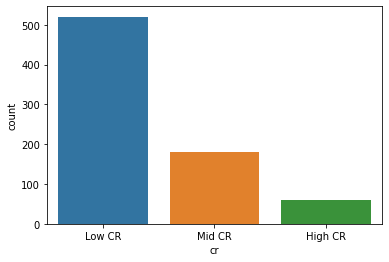

In [312]:
 sns.countplot(x='cr',data=df)

We can see that most of the monsters are at lower levels (up to level 6).
</br>Not too many Monstres pass level 18

In [313]:
df['cr'].value_counts()

Low CR     520
Mid CR     180
High CR     61
Name: cr, dtype: int64

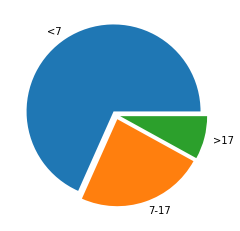

In [314]:
# Pie Chart (monster count by level groups - low, mid, high):
low = len(df[(df['cr']=='Low CR')])
mid = len(df[(df['cr']=='Mid CR')])
high = len(df[(df['cr']=='High CR')])
plt.pie([low,mid,high],labels=['<7', '7-17', '>17'],explode=[0.05,0.05,0.05] )
plt.show()

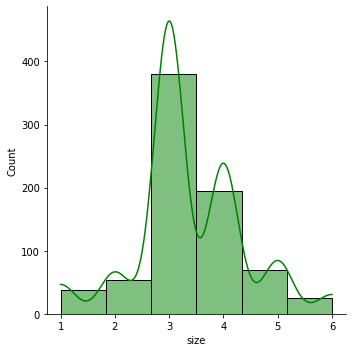

In [315]:
# Size of Monsters Distribution
sns.displot(x=df['size'],kde=True, color='green',bins=6)

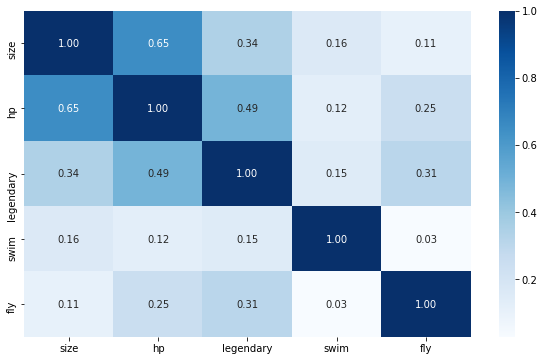

In [316]:
# Parameter correlation:
plt.figure(figsize=(10,6))
corr = df.corr()
sns.heatmap(corr,annot=True,cmap='Blues',fmt='.2f')

Looks like good high correlation between hitpoints(hp) and challenge rating(cr) variables - see above and below

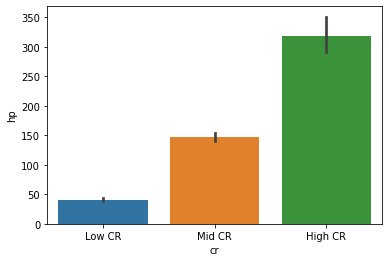

In [317]:
# Visualize the correlation hp-cr
sns.barplot(x='cr', y='hp', data=df)

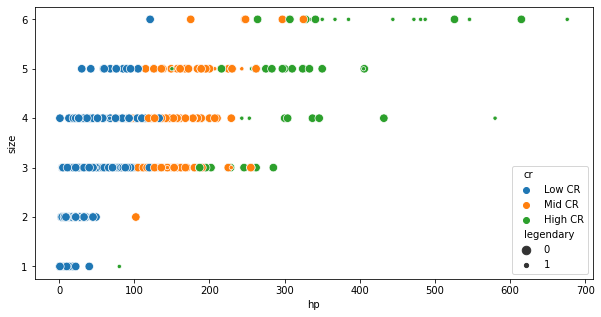

In [318]:
# The scatter graph shows us many legendary (espeacialy flying) monsterts at high cr level with lots of hp 
plt.figure(figsize=(10,5))
sns.scatterplot(x='hp', y='size', hue='cr', size='legendary', data=df)

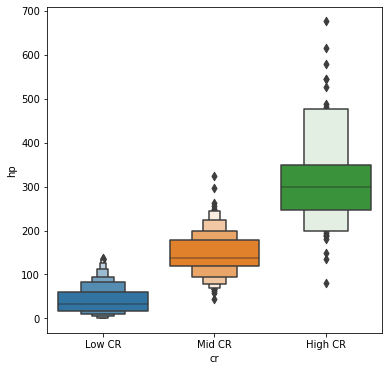

In [319]:
# Exceptional values in boxplot (for the hp-cr correlation)
plt.figure(figsize=(6,6))
sns.boxenplot(x='cr', y='hp', data=df)

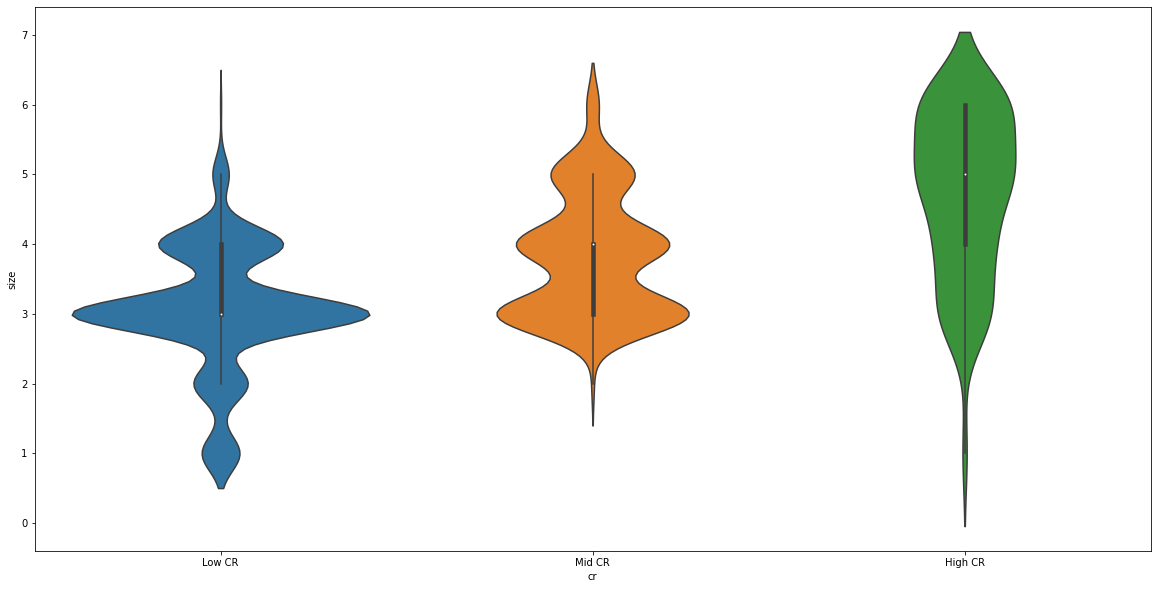

In [320]:
# Exceptional values in boxplot (for the hp-cr correlation)
plt.figure(figsize=(20,10))
sns.violinplot(x='cr', y='size', data=df)

In [321]:
y = df['cr']
X = df.drop(['cr'],axis=1)
X.corr()

,size,hp,legendary,swim,fly
size,1.00,0.65,0.34,0.16,0.11
hp,0.65,1.00,0.49,0.12,0.25
legendary,0.34,0.49,1.00,0.15,0.31
swim,0.16,0.12,0.15,1.00,0.03
fly,0.11,0.25,0.31,0.03,1.00


In [322]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15, random_state=17)
print("Train: ", X_train.shape, y_train.shape)
print("Train: ", X_test.shape, y_test.shape)

Train:  (646, 5) (646,)
Train:  (115, 5) (115,)


In [323]:
# Distance calculation to Zeros 
def distance_np(np1):
  np2 = np.zeros_like(np1)
  return np.linalg.norm(np1-np2)

In [324]:
# Show stat info:
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame(X_train).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
size,646.00,3.38,1.04,1.00,3.00,3.00,4.00,6.00
hp,646.00,89.26,94.74,1.00,22.00,58.50,126.00,676.00
legendary,646.00,0.06,0.23,0.00,0.00,0.00,0.00,1.00
swim,646.00,0.13,0.33,0.00,0.00,0.00,0.00,1.00
fly,646.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00


In [325]:
#scaler = StandardScaler() # 0.87
#scaler = Normalizer() # 0.89
#scaler = MinMaxScaler() # 0.86
scaler = RobustScaler() # 0.90

In [326]:
# Fit & transform
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pd.DataFrame(X_train).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,646.00,0.38,1.04,-2.00,0.00,0.00,1.00,3.00
1,646.00,0.30,0.91,-0.55,-0.35,0.00,0.65,5.94
2,646.00,0.06,0.23,0.00,0.00,0.00,0.00,1.00
3,646.00,0.13,0.33,0.00,0.00,0.00,0.00,1.00
4,646.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00


In [327]:
# check some of the distances to make sure it's not too far apart...
pd.DataFrame(X_train[:17]).apply(lambda np1: distance_np(np1),axis=1)

0    2.24
1    1.11
2    0.66
3    0.33
4    0.16
5    1.02
6    3.86
7    1.46
8    1.20
9    2.34
10   0.66
11   1.04
12   1.46
13   1.04
14   1.42
15   1.42
16   1.07
dtype: float64

In [328]:
print('Shape: ', X_train.shape, y_train.shape)
calcTime = time.time()
params = {
    'algorithm': ['ball_tree','kd_tree','brute'],
    'n_neighbors': [3,5,10,15,30], 
    'weights': ['uniform','distance']
}
myKnn = GridSearchCV(KNeighborsClassifier(),params,cv=5)
myKnn.fit(X_train,y_train)
calcTime = time.time() - calcTime
print ('Train time: {:2f}'.format(calcTime))
results = pd.DataFrame(myKnn.cv_results_)
results.head(3)

Shape:  (646, 5) (646,)
Train time: 1.119589


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00,0.00,0.01,0.00,ball_tree,3,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 3, '...",0.85,0.90,0.86,0.83,0.88,0.86,0.03,21
1,0.00,0.00,0.00,0.00,ball_tree,3,distance,"{'algorithm': 'ball_tree', 'n_neighbors': 3, '...",0.82,0.88,0.84,0.81,0.88,0.85,0.03,30
2,0.00,0.00,0.01,0.00,ball_tree,5,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 5, '...",0.85,0.88,0.87,0.88,0.90,0.87,0.02,11


In [329]:

results[['param_algorithm','param_n_neighbors','param_weights','mean_test_score','rank_test_score']]

,param_algorithm,param_n_neighbors,param_weights,mean_test_score,rank_test_score
0,ball_tree,3,uniform,0.86,21
1,ball_tree,3,distance,0.85,30
2,ball_tree,5,uniform,0.87,11
3,ball_tree,5,distance,0.86,26
4,ball_tree,10,uniform,0.89,2
5,ball_tree,10,distance,0.87,14
6,ball_tree,15,uniform,0.89,7
7,ball_tree,15,distance,0.87,16
8,ball_tree,30,uniform,0.89,4
9,ball_tree,30,distance,0.86,23


In [330]:
# Those are the best Params:
myKnn.best_params_

{'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'uniform'}

In [331]:
# Average score of the algorithems:
results[['param_algorithm', 'mean_test_score']].groupby('param_algorithm').mean('mean_test_score')


,mean_test_score
param_algorithm,
ball_tree,0.87
brute,0.87
kd_tree,0.87


we can see that we found the best combination using brute algorithem, however, the mean of all algorithm results is the same for all of them. we will use the best...

In [332]:
# Average score of the number of neighbors:
results[['param_n_neighbors', 'mean_test_score']].groupby('param_n_neighbors').mean('mean_test_score')

,mean_test_score
param_n_neighbors,
3,0.86
5,0.87
10,0.88
15,0.88
30,0.87


we can see that in avarege the score climbs to its climax at 10-15 neighbors, above or below that range the score is lower

In [333]:
# Average score of the weights (seems uniform is slightly better):
results[['param_weights', 'mean_test_score']].groupby('param_weights').mean('mean_test_score')

,mean_test_score
param_weights,
distance,0.86
uniform,0.88


In [334]:
runKNN = KNeighborsClassifier(
    algorithm=myKnn.best_params_['algorithm'],
    n_neighbors=myKnn.best_params_['n_neighbors'],
    weights=myKnn.best_params_['weights']
)
runKNN.fit(X_train,y_train)
runKNN.score(X_test,y_test)

0.8695652173913043

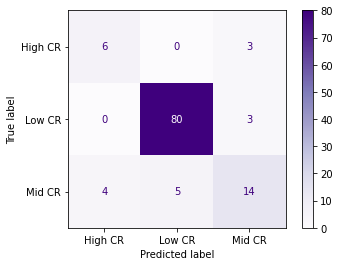

In [335]:
plot_confusion_matrix(runKNN,X_test,y_test, cmap='Purples')

In [336]:
# Those are nice results !!! 
# Espeacialy for the low level Monsters (the majorithy of the monsters in the game)
# The others (mid & high) are more than 50% as well
pred = runKNN.predict(X_test)
print(classification_report(y_test,pred,digits=3))

              precision    recall  f1-score   support

     High CR      0.600     0.667     0.632         9
      Low CR      0.941     0.964     0.952        83
      Mid CR      0.700     0.609     0.651        23

    accuracy                          0.870       115
   macro avg      0.747     0.746     0.745       115
weighted avg      0.866     0.870     0.867       115



In [337]:
# Now the same with SVM:
print('Shape: ', X_train.shape, y_train.shape)
calcTime = time.time()
params = {
    'kernel': ('linear','poly','rbf', 'sigmoid'),
    'C': [0.1,1,10], 
    'gamma': ['scale','auto']
}
mySvm = GridSearchCV(SVC(),params,cv=5)
mySvm.fit(X_train,y_train)
calcTime = time.time() - calcTime
print ('Train time: {:2f}'.format(calcTime))
results = pd.DataFrame(mySvm.cv_results_)
results.head(3)

Shape:  (646, 5) (646,)
Train time: 0.953498


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00,0.00,0.00,0.00,0.10,scale,linear,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.88,0.91,0.88,0.93,0.91,0.90,0.02,8
1,0.01,0.00,0.00,0.00,0.10,scale,poly,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.82,0.83,0.84,0.81,0.78,0.82,0.02,19
2,0.01,0.00,0.00,0.00,0.10,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.86,0.88,0.87,0.89,0.89,0.88,0.01,12


In [338]:
results[['param_C','param_gamma','param_kernel','mean_test_score','rank_test_score']]

,param_C,param_gamma,param_kernel,mean_test_score,rank_test_score
0,0.10,scale,linear,0.90,8
1,0.10,scale,poly,0.82,19
2,0.10,scale,rbf,0.88,12
3,0.10,scale,sigmoid,0.83,17
4,0.10,auto,linear,0.90,8
5,0.10,auto,poly,0.77,21
6,0.10,auto,rbf,0.87,13
7,0.10,auto,sigmoid,0.83,16
8,1,scale,linear,0.91,1
9,1,scale,poly,0.85,14


In [339]:
# Those are the best Params (with 0.91 mean_test_score):
mySvm.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

         mean_test_score
param_C                 
0.10                0.85
1.00                0.86
10.00               0.85


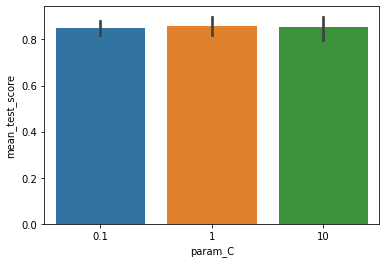

In [340]:
# we can see that param_C=1 is a bit higher (0.86)...
print(results[['param_C','mean_test_score']].groupby('param_C').mean('mean_test_score'))
sns.barplot(y='mean_test_score', x='param_C', data=results)

             mean_test_score
param_gamma                 
auto                    0.85
scale                   0.85


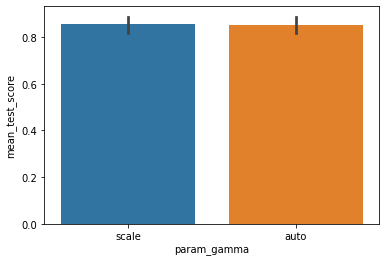

In [341]:
# we can see the gamma is the same on avrg (0.85)...
print(results[['param_gamma','mean_test_score']].groupby('param_gamma').mean('mean_test_score'))
sns.barplot(y='mean_test_score', x='param_gamma', data=results)

              mean_test_score
param_kernel                 
linear                   0.91
poly                     0.83
rbf                      0.90
sigmoid                  0.78


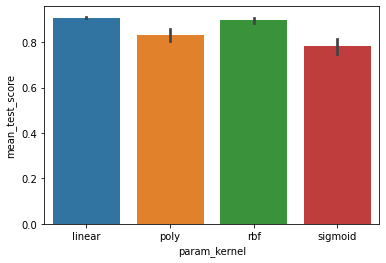

In [342]:
# we can see that the linear is the highest (0.91)...
print(results[['param_kernel','mean_test_score']].groupby('param_kernel').mean('mean_test_score'))
sns.barplot(y='mean_test_score', x='param_kernel', data=results)

In [343]:
runSvm = SVC(
    C=mySvm.best_params_['C'],
    gamma=mySvm.best_params_['gamma'],
    kernel=mySvm.best_params_['kernel']
)
runSvm.fit(X_train,y_train)
runSvm.score(X_test,y_test)

0.8956521739130435

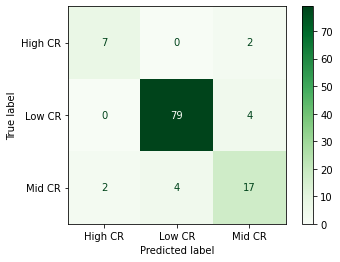

In [344]:
plot_confusion_matrix(runSvm,X_test,y_test, cmap='Greens')

In [345]:
# Those are much better results than KNN!!! 
# Low level Monsters are up to 95%
# Significant improvement with mid & high Monsters !
pred = runSvm.predict(X_test)
print(classification_report(y_test,pred,digits=3))

              precision    recall  f1-score   support

     High CR      0.778     0.778     0.778         9
      Low CR      0.952     0.952     0.952        83
      Mid CR      0.739     0.739     0.739        23

    accuracy                          0.896       115
   macro avg      0.823     0.823     0.823       115
weighted avg      0.896     0.896     0.896       115



# **I pick SVM!**